In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [2]:
# Change these 
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"

In [3]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [5]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')
print(len(meta_files))
idx = 230
print(meta_files[idx])

236
./training_data_filtered/training_data/v2.2\2-94-3_meta.pkl


In [6]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

C:\Users\GAUSS\AppData\Local\Temp\ipykernel_121616\3752261350.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow', NUM_OBJECTS)


## Get familiar with the data

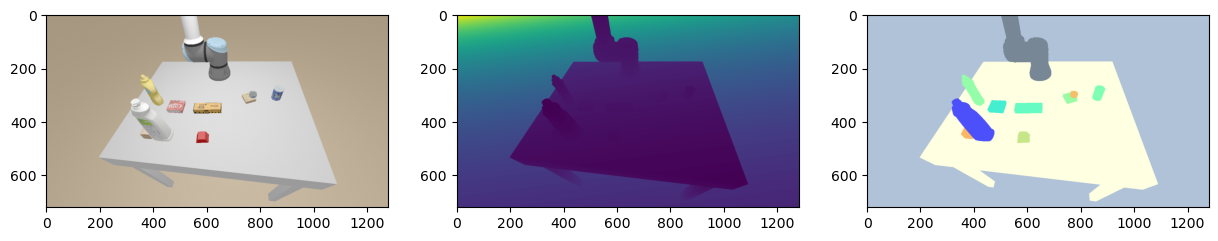

In [7]:
meta = load_pickle(meta_files[idx])
rgb = np.array(Image.open(rgb_files[idx])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[idx])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[idx]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

segmentation mask unique labels: [ 8 30 35 39 42 43 50 57 58 79 80 81]
Object names: ['bleach_cleanser', 'gelatin_box', 'jenga', 'master_chef_can', 'mustard_bottle', 'nine_hole_peg_test', 'prism', 'pudding_box', 'tuna_fish_can', 'wood_block']
Object IDs: [ 8 30 35 39 42 43 50 51 57 58]
Valid pixel counts for each object ID:
Object ID 8: 12992 pixels
Object ID 30: 2810 pixels
Object ID 35: 4051 pixels
Object ID 39: 1998 pixels
Object ID 42: 4485 pixels
Object ID 43: 1321 pixels
Object ID 50: 1801 pixels
Object ID 51: 0 pixels
Object ID 57: 657 pixels
Object ID 58: 998 pixels


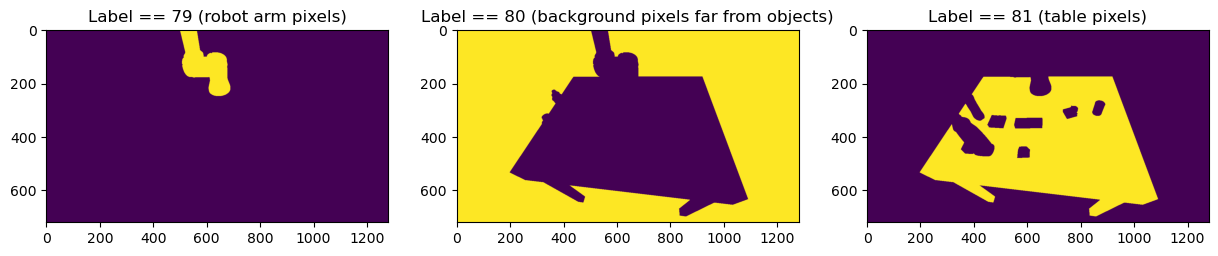

In [19]:
print("segmentation mask unique labels:", np.unique(label))
print(f"Object names: {meta['object_names']}")
print(f"Object IDs: {meta['object_ids']}")

# count valid pixels for each object
valid_pixel_counts = {}
for obj_id in meta['object_ids']:
    count = np.sum(label == obj_id)
    valid_pixel_counts[obj_id] = count
    
print("Valid pixel counts for each object ID:")
for obj_id, count in valid_pixel_counts.items():
    print(f"Object ID {obj_id}: {count} pixels")
    
# show what label=79/80/81 means
img_79 = label == 79
img_80 = label == 80
img_81 = label == 81
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Label == 79 (robot arm pixels)")
plt.imshow(img_79)
plt.subplot(1, 3, 2)
plt.title("Label == 80 (background pixels far from objects)")
plt.imshow(img_80)
plt.subplot(1, 3, 3)
plt.title("Label == 81 (table pixels)")
plt.imshow(img_81)
plt.show()

In [9]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
print(poses_world.shape)    # 4D transformation matrix, homogeneous coordinates

box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
print(box_sizes.shape)    # xyz scale

(10, 4, 4)
(10, 3)


## Lift depth to point cloud

In [10]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
print(points_viewer.shape)
# points_viewer = points_viewer[::-1, ::-1, :]

(720, 1280, 3)


In [11]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

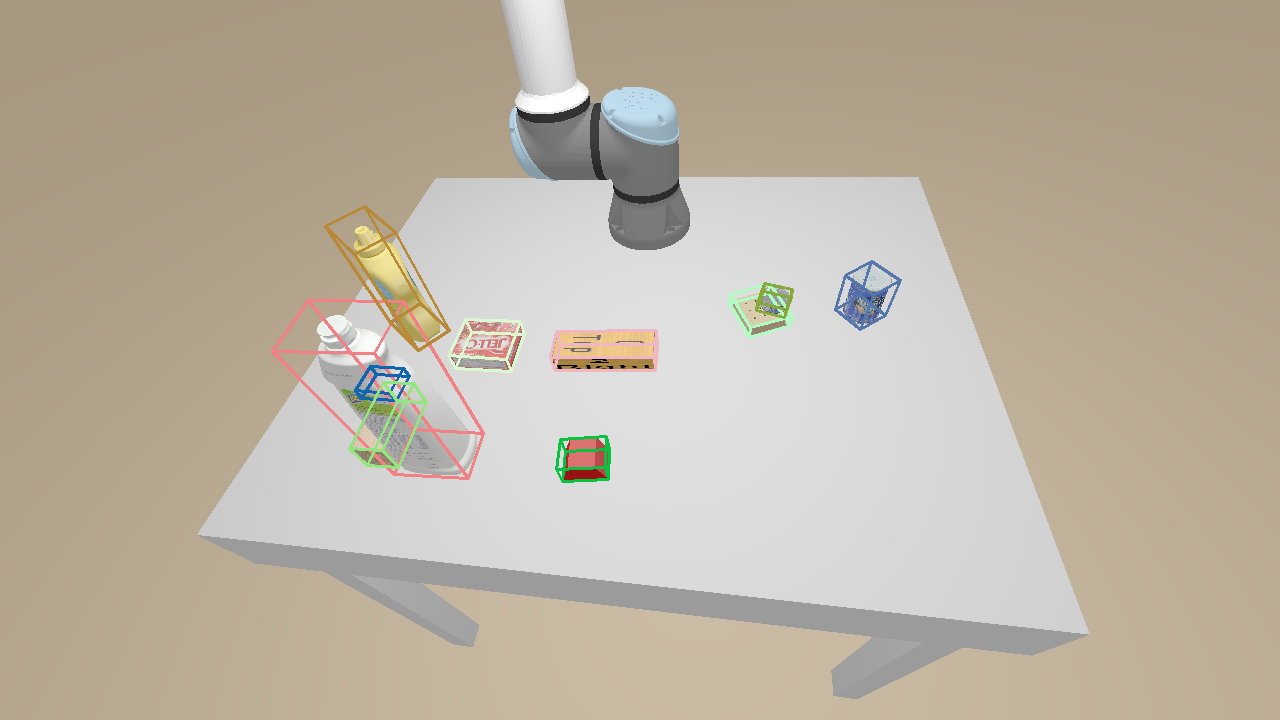

In [12]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [15]:
load_pickle("./testing_data_pose_filtered/testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

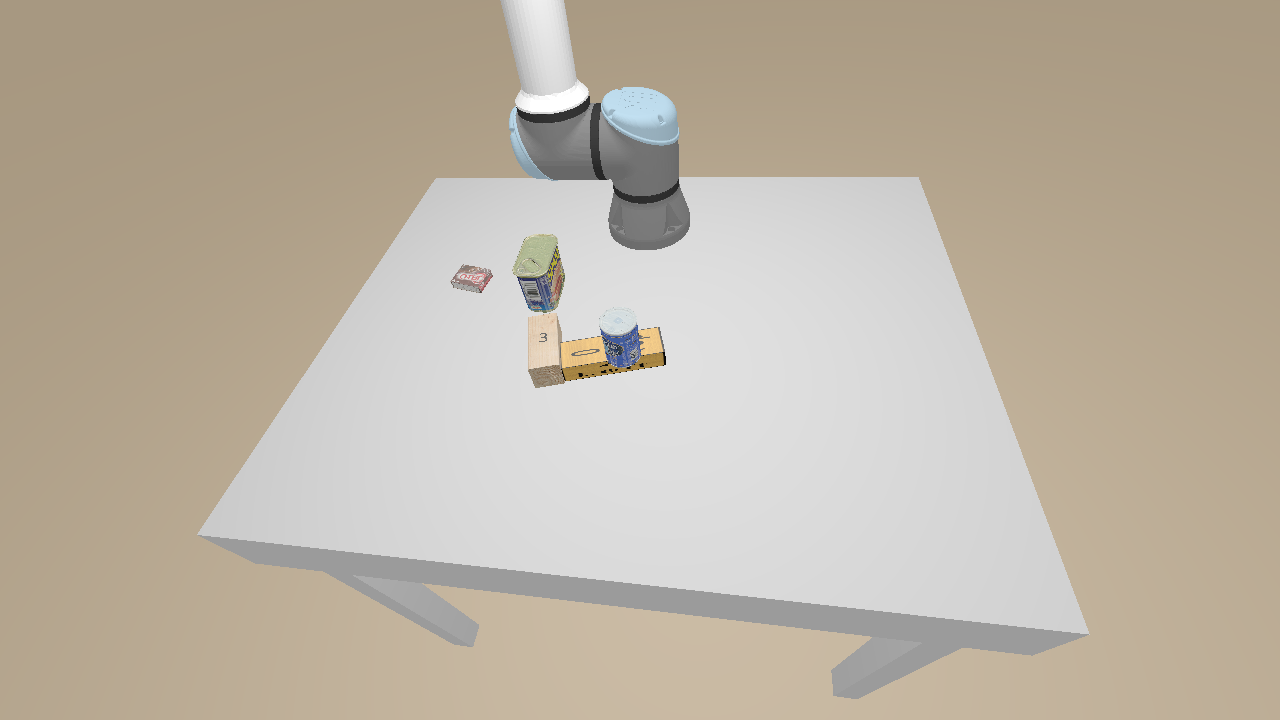

In [16]:
Image.open("./testing_data_pose_filtered/testing_data/v2.2/1-1-1_color_kinect.png")

## ICP

### Coordinate Frame Table

| Frame Name         | Definition                                                                 | Typical Data Example                |
|-------------------|----------------------------------------------------------------------------|-------------------------------------|
| Object Canonical  | Mesh model's own coordinate system, centered and scaled to canonical size   | `mesh_points` (sampled from mesh)   |
| Camera            | Camera's coordinate system, origin at camera center                         | `points` (from depth image)         |
| World             | Global scene coordinate system, fixed for dataset/environment               | Final object pose in world frame    |

- **Object Canonical → Camera:** Use ICP to align mesh to observed points.
- **Camera → World:** Use camera extrinsic matrix to convert object pose to world frame.
- **Object Canonical → World:** Apply ground-truth pose matrix to mesh points.
